In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib import colors
from scipy import stats

# --------------- IMPORTING THE DATA --------------- #

# Evacuation Data
evacdata = pd.read_csv('./output_new3/walking/gy-evac walking-table.csv', skiprows=6).sort_values(by=['terminate-evac-distance-km', 'ticks']).reset_index(drop=True)
# renaming the column to something that isn't cursed
evacdata.rename(columns={'[run number]': 'run_number'}, inplace=True)
evacdata.rename(columns={'initial-people': 'population'}, inplace=True)
evacdata.rename(columns={'max-walking-distance-km': 'walk_dist'}, inplace=True)
evacdata.columns = evacdata.columns.str.replace('-', '_')
# calculate time in minutes
evacdata['time_minutes'] = evacdata['ticks'] * evacdata['tick_time_in_mins']
evacdata['warning_interval_time_mins-1'] = (evacdata['warning_interval_time_mins'] / 60) -0.5
evacdata['evacuated_perc'] = evacdata['get_no_evacuated'] / evacdata['population'] * 100
evacdata['evacuating_perc'] = evacdata['get_no_evacuating'] / evacdata['population'] * 100

# Journey Time Data
jm_files = glob.glob('./output_new3/walking/jm*.csv')
journey_metrics_list = [pd.read_csv(file) for file in jm_files]
# Extract tick number from file names and add as a column to each dataframe
for i, file in enumerate(jm_files):
    tick_number = int(file.split('/')[-1].split('_')[7][1])
    journey_metrics_list[i]['walk_dist'] = tick_number
# Concatenate the dataframes
journey_metrics = pd.concat(journey_metrics_list, ignore_index=True).sort_values(by=['walk_dist', 'start_tick']).reset_index(drop=True)
# calculate time in minutes
journey_metrics['start_time_minutes'] = journey_metrics['start_tick'] * 0.3 # 0.3 minutes per tick

# calculate normalised journey time
journey_metrics['normalised_journey_time'] = journey_metrics['actual_time'] / journey_metrics['ideal_time']

# calculate the mean normalised journey time every 30 minutes for each run
# Bin the start_tick at intervals of 120 (corresponding to 30 minutes)
journey_metrics['start_time_bin'] = pd.cut(journey_metrics['start_time_minutes'], bins=np.arange(-15, journey_metrics['start_tick'].max() + 45, 30))
# Calculate the mean normalised journey time for each bin
mean_normalised_journey_time_per_bin = journey_metrics.groupby('start_time_bin')['normalised_journey_time'].mean().reset_index()
# Calculate the mean normalised journey time for each bin for each run
mean_normalised_journey_time_per_bin_per_run = journey_metrics.groupby(['walk_dist', 'start_time_bin'])['normalised_journey_time'].mean().reset_index()

In [47]:
journey_metrics.tail()

,car_id,passengers,ideal_time,actual_time,start_tick,end_tick,walk_dist,start_time_minutes,normalised_journey_time,start_time_bin
18862,31414,1,3.276875,3.6,999,1010,5,299.7,1.098608,"(285, 315]"
18863,22971,1,3.276875,3.6,1099,1110,5,329.7,1.098608,"(315, 345]"
18864,7567,1,3.209375,3.3,1299,1309,5,389.7,1.028238,"(375, 405]"
18865,18149,1,3.776875,3.9,1399,1411,5,419.7,1.032600,"(405, 435]"
18866,29638,1,3.276875,3.6,1999,2010,5,599.7,1.098608,"(585, 615]"


In [48]:
evacdata.walk_dist.unique()

array([5, 4, 7, 1, 3, 6, 2, 0])

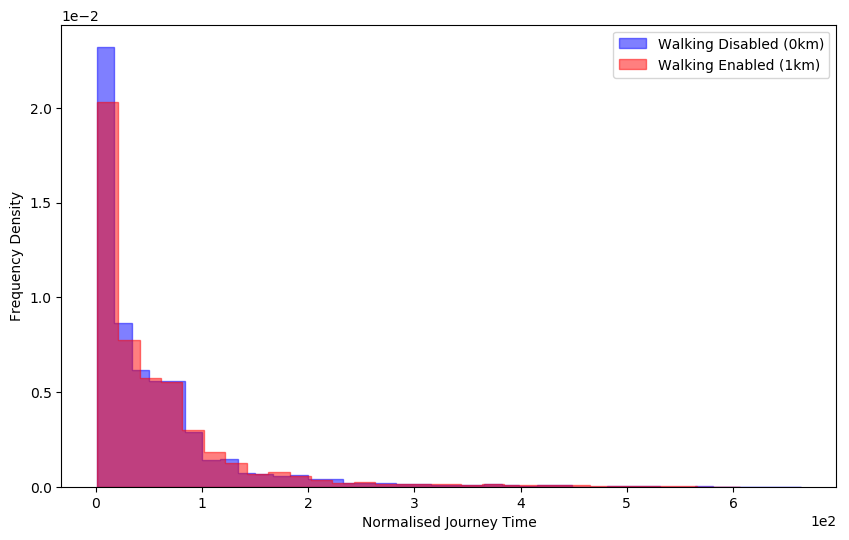

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.hist(journey_metrics[journey_metrics['walk_dist'] == 0]['normalised_journey_time'],  histtype = 'stepfilled', bins=40, color='b', edgecolor='b', alpha=0.5, density=True, label = 'Walking Disabled (0km)')
plt.hist(journey_metrics[journey_metrics['walk_dist'] == 1]['normalised_journey_time'], bins=30, histtype = 'stepfilled',color = 'r',  edgecolor='r', alpha=0.5, density=True, label = 'Walking Enabled (1km)')
#plt.xscale('log')
#plt.xlim(0, 0.6e7)

ax.set_xlabel('Normalised Journey Time')
ax.set_ylabel('Frequency Density')
plt.legend()

ax.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))
plt.savefig('figures_v02/walking_hist_njt.png')

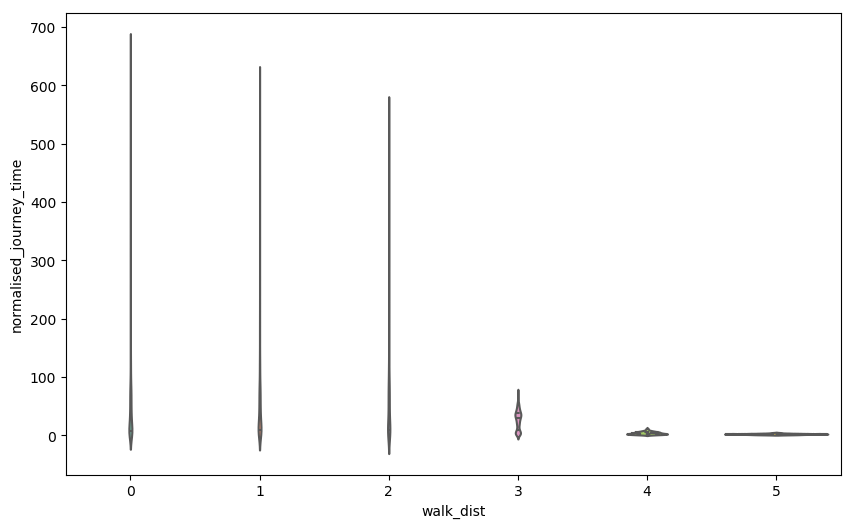

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.violinplot(data=journey_metrics, x='walk_dist', y='normalised_journey_time', ax=ax, inner='quartile', linewidth=1.5, palette='Set2')